In [161]:
import mcmclib
import torch
import matplotlib.pyplot as plt
import random
import numpy as np


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [6]:
golden_sample = torch.load('mcmc_samples_20000.pt')
dataset = torch.load("dataset.pt")
teams = torch.load("teams.pt")
teams_number = list(range(len(teams)))

session = mcmclib.MCMC_Session(seed=123)

# Dataset Exploration

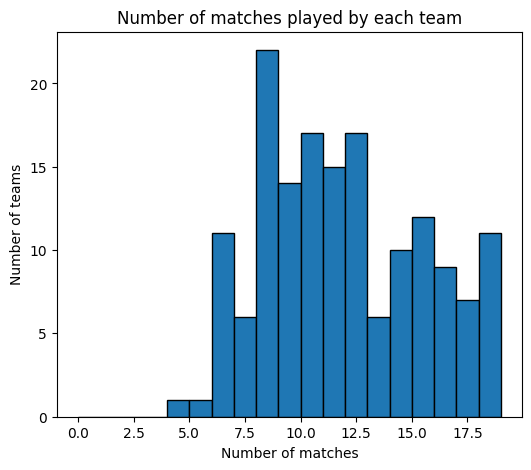

In [60]:
# group matches by who plays
# this can be used as a baseline for future heuristics

matches_by_team = {team: [] for team in teams_number}

for match in dataset:
    matches_by_team[match[0]].append(match)
    matches_by_team[match[1]].append(match)

# set size
plt.figure(figsize=(6, 5))
plt.hist([len(matches_by_team[team])
         for team in teams_number],
         bins=range(0, 20),
         edgecolor='black')
plt.title("Number of matches played by each team")
plt.xlabel("Number of matches")
plt.ylabel("Number of teams")

plt.show()

Text(0, 0.5, 'Number of matches')

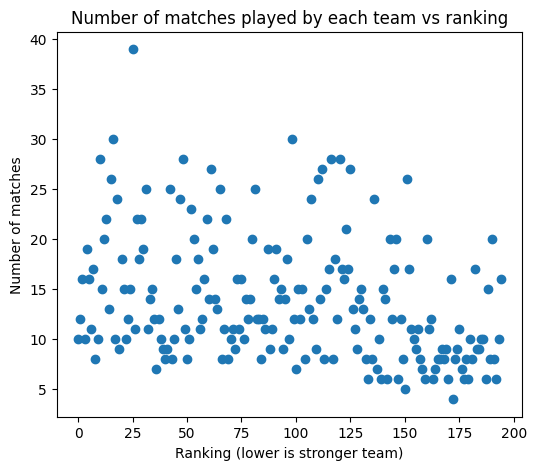

In [71]:
golden_ranking = mcmclib.construct_ranking(golden_sample, teams_number)

# plot the number of matches times the ranking of the team
plt.figure(figsize=(6, 5))
plt.plot([golden_ranking[team] for team in teams_number], [
    len(matches_by_team[team]) for team in teams_number], 'o')
plt.title("Number of matches played by each team vs ranking")
plt.xlabel("Ranking (lower is stronger team)")
plt.ylabel("Number of matches")

## Observations
1. Judges tend to visit interesting projects more which happen to rank higher
2. The lower limit for # of visits is 5 judges and that project seems to do poorly in ranking 

---

# Heuristic #1:
Focus on improving the top 10 only

> The following is cheating because it uses win rate calculated by the whole dataset
> Ideally, we can have similar boundaries using base minimum 5 matches

Text(0, 0.5, 'Losses')

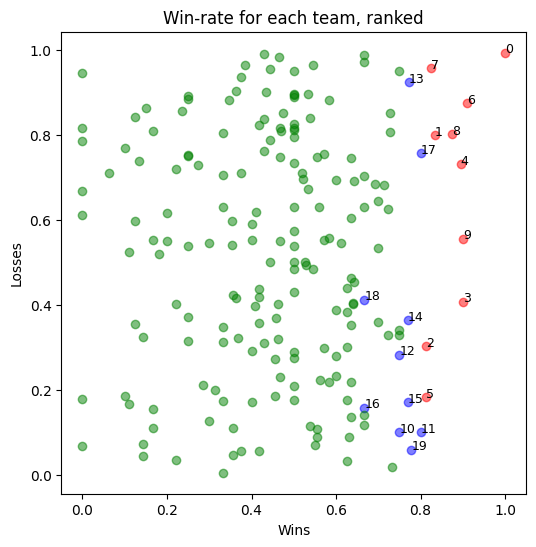

In [116]:
# get top 20 teams from golden ranking
top_teams = sorted(teams_number, key=lambda team: golden_ranking[team])

# plot all teams wins vs losses and highlight top 20 teams in different color
plt.figure(figsize=(6, 6))
for team in teams_number:
    wins = sum([1 for match in matches_by_team[team] if match[0] == team])
    losses = len(matches_by_team[team]) - wins

    wins /= len(matches_by_team[team])
    losses /= len(matches_by_team[team])

    # random y to avoid overlapping points
    y = torch.rand(1)
    if team in top_teams[:10]:
        plt.plot(wins, y, 'ro', alpha=0.5)
        plt.text(wins, y, top_teams.index(team), fontsize=9)
    elif team in top_teams[:20]:
        plt.plot(wins, y, 'bo', alpha=0.5)
        plt.text(wins, y, top_teams.index(team), fontsize=9)
    else:
        plt.plot(wins, y, 'go', alpha=0.5)

plt.title("Win-rate for each team, ranked")
plt.xlabel("Wins")
plt.ylabel("Losses")

Text(0, 0.5, 'Losses')

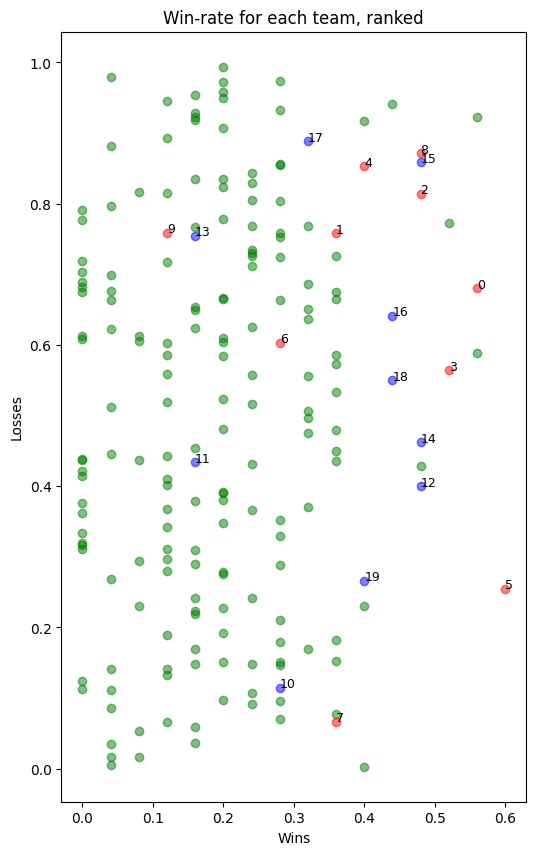

In [221]:
# !!! This time, we will only use a sample of 5 matches for each team
subset_matches_by_team = {
    team: matches_by_team[team][:5] for team in teams_number}

win_rates = {}
for team in teams_number:
    wins = sum([1 for match in subset_matches_by_team[team] if match[0] == team])
    win_rates[team] = wins / len(subset_matches_by_team[team])


# first pass
for _ in range(1):
    new_win_rates = {}
    for team in teams_number:
        matches = subset_matches_by_team[team]
        wins_weight = sum([win_rates[match[1]]
                           for match in matches if match[0] == team])
        new_win_rates[team] = wins_weight / len(matches)

    win_rates = new_win_rates

# get top 20 teams in win rate
top_teams_wr = sorted(
    teams_number, key=lambda team: win_rates[team], reverse=True)

for team in top_teams_wr[:20]:
    subset_matches_by_team[team] = matches_by_team[team]


# get top 20 teams from golden ranking
top_teams = sorted(teams_number, key=lambda team: golden_ranking[team])

# plot all teams wins vs losses and highlight top 20 teams in different color
plt.figure(figsize=(6, 10))
for team in teams_number:
    # random y to avoid overlapping points
    y = torch.rand(1)

    wr = win_rates[team]

    if team in top_teams[:10]:
        plt.plot(wr, y, 'ro', alpha=0.5)
        plt.text(wr, y, top_teams.index(team), fontsize=9)
    elif team in top_teams[:20]:
        plt.plot(wr, y, 'bo', alpha=0.5)
        plt.text(wr, y, top_teams.index(team), fontsize=9)
    else:
        plt.plot(wr, y, 'go', alpha=0.5)

plt.title("Win-rate for each team, ranked")
plt.xlabel("Wins")
plt.ylabel("Losses")

In [225]:
matches = set()
for x in matches_by_team.values():
    for i in x:
        matches.add(i)

len(matches)

1230

# With selective matching

In [223]:
_ = session.run(list(matches), [5, 10, 50, 100, 200, 300], len(teams))

Sample: 100%|██████████| 320/320 [03:55,  1.36it/s, step size=6.61e-01, acc. prob=0.556]


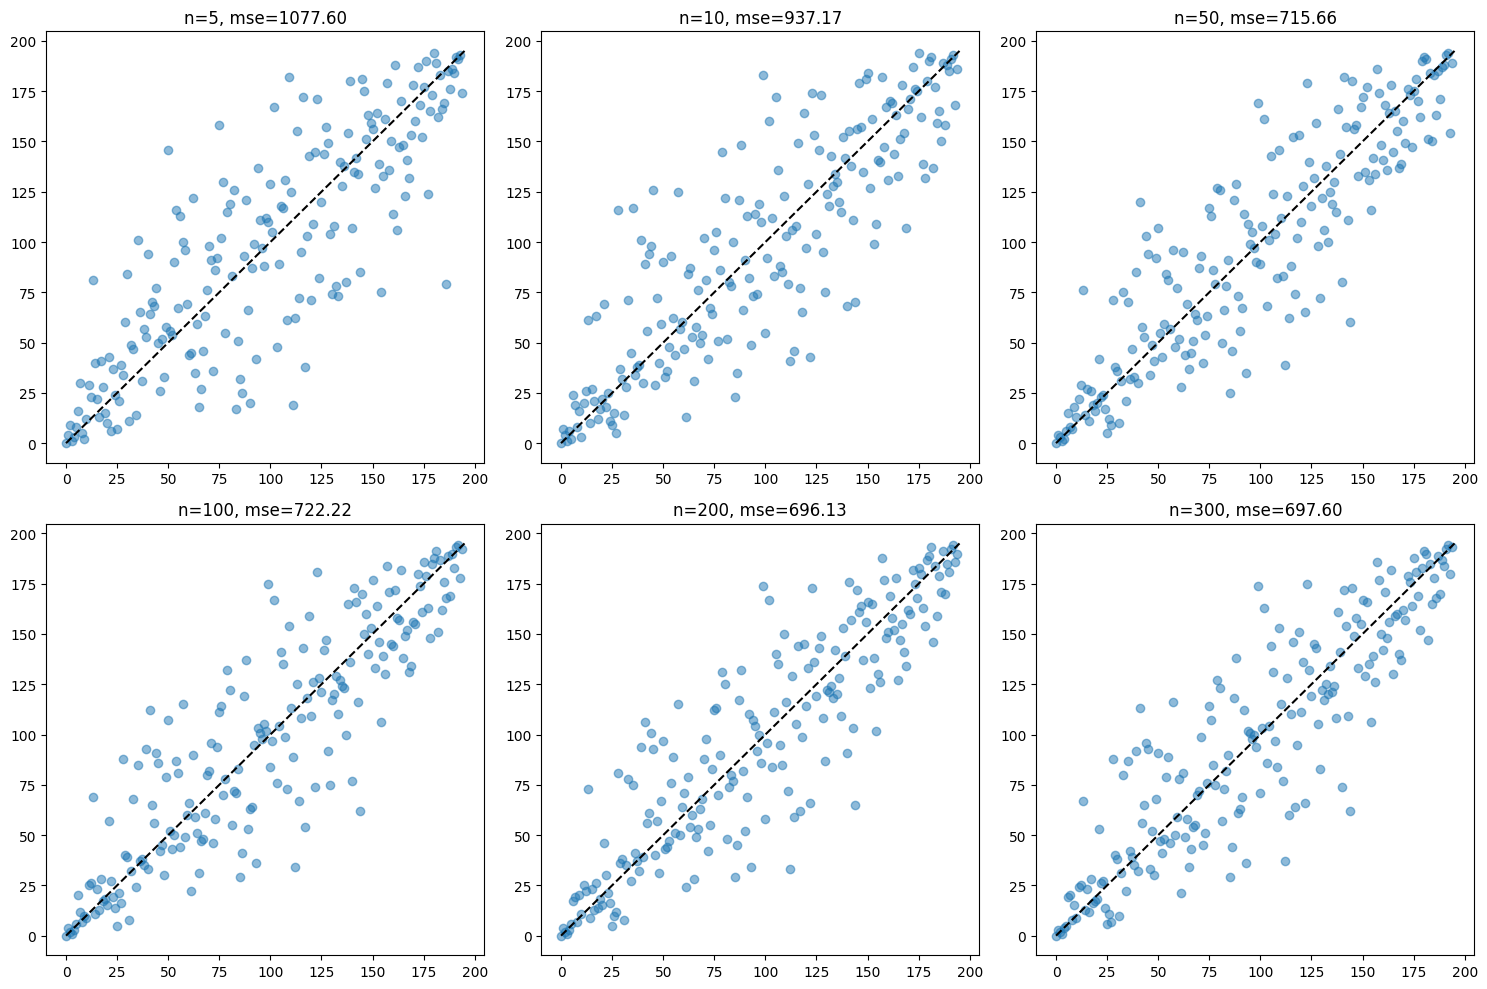

In [224]:
session.compare(golden_sample, teams_number)
plt.tight_layout()

In [ ]:
session.compare(golden_sample, teams_number)
plt.tight_layout()

# Without new selective matching

In [202]:
_ = session.run(list(matches), [5, 10, 50, 100, 200, 300], len(teams))

Sample: 100%|██████████| 320/320 [03:19,  1.60it/s, step size=6.91e-01, acc. prob=0.483]


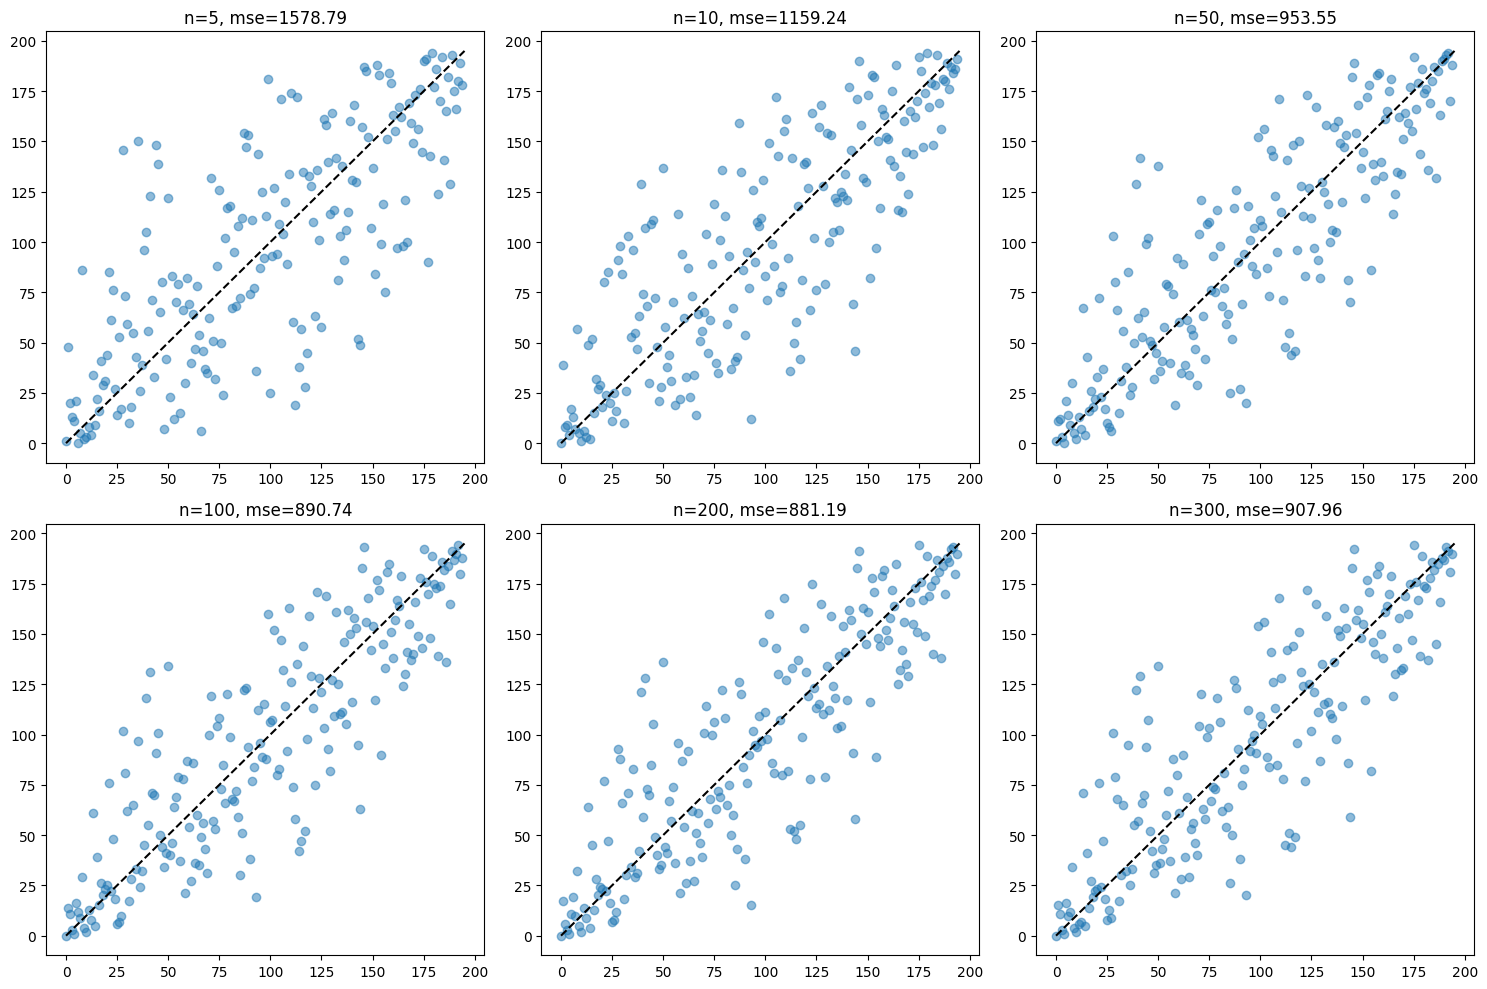

In [210]:
session.compare(golden_sample, teams_number)
plt.tight_layout()

In [226]:
761 / len(matches)

0.6186991869918699